In [71]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

import tensorflow as tf
from tensorflow.keras import backend as K
tf.enable_eager_execution()

from sklearn import svm
from sklearn.svm import SVR
from sklearn import metrics

from scipy import stats
from datetime import datetime

from sklearn.metrics import mean_squared_error,mean_absolute_error
from math import sqrt

mpl.rcParams['figure.figsize'] = (12, 9)
mpl.rcParams['axes.grid'] = False

Variable initalizations to be used later

In [72]:
tf.random.set_random_seed(13)
BATCH_SIZE = 256
BUFFER_SIZE = 10000
STEP = 1

The file containing the airport weather data is read in, skipping rows which contain unneeded information

In [73]:
dubAirWD = pd.read_csv('hly532.csv', skiprows = 22)
dubAirWD.columns = dubAirWD.iloc[0]
dubAirWD = dubAirWD.drop(dubAirWD.index[0])

C:\Users\Matthew\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The CSV containing the UCD Veterinary Building Data is then read in. The data is prepared into a usable format for the models

In [74]:
ucdBD = pd.read_csv('UCD_Belfield_Veterinary Science.csv', skiprows = 1)
ucdBD.drop(['Values'], axis = 1, inplace = True)

ucdBD = ucdBD.stack().reset_index()
ucdBD.drop(['level_0'], axis = 1, inplace = True)

In [75]:
dateTemp = 0
countBool = False
x = 0

while x < (len(ucdBD)):
    if countBool:
        countBool = False
        x -= 1
        
    if ucdBD.iloc[x,0] == "Date":
        ucdBD.iloc[x,0] = ucdBD.iloc[x,1]
        dateTemp = ucdBD.iloc[x,1]
        ucdBD = ucdBD.drop(ucdBD.index[x])
        countBool = True
    else:
        ucdBD.iloc[x,0] = str(dateTemp) + " " + ucdBD.iloc[x,0]
        
    x += 1

In [76]:
ucdBD.columns = ['Date', 'Usage']
ucdBD.index = ucdBD['Date']
ucdBD.drop(['Date'], axis = 1, inplace = True)

In [77]:
ucdBD

,Usage
Date,
01/01/2007 00:00,36.08
01/01/2007 00:15,36.86
01/01/2007 00:30,36.57
01/01/2007 00:45,37.2
01/01/2007 01:00,36.95
...,...
18/04/2020 10:00,38.73
18/04/2020 10:15,37.9075
18/04/2020 10:30,36.6575


In [78]:
ucdBD.index = pd.to_datetime(ucdBD.index, utc = True)

In [79]:
ucdBD = ucdBD.astype(float).resample('60min').mean()

ucdBD

,Usage
Date,
2007-01-01 00:00:00+00:00,36.677500
2007-01-01 01:00:00+00:00,36.875000
2007-01-01 02:00:00+00:00,36.430000
2007-01-01 03:00:00+00:00,38.807500
2007-01-01 04:00:00+00:00,36.592500
...,...
2020-12-04 19:00:00+00:00,40.165624
2020-12-04 20:00:00+00:00,40.201249
2020-12-04 21:00:00+00:00,37.863124


In [80]:
if "ind" in dubAirWD.columns:
    dubAirWD.drop(['ind'], axis = 1, inplace = True)

In [81]:
dubAirWD.index = dubAirWD['date']
dubAirWD.drop(['date'], axis = 1, inplace = True)

In [82]:
dubAirWD.index = pd.to_datetime(dubAirWD.index, utc = True)
dubAirWD

,rain,temp,wetb,dewpt,vappr,rhum,msl,wdsp,wddir,ww,w,sun,vis,clht,clamt
date,,,,,,,,,,,,,,,
1990-01-01 00:00:00+00:00,0.1,9,8.1,7.1,10.1,88,1008.3,10,140,50,52,0,7000,7,8
1990-01-01 01:00:00+00:00,0,8.9,8,7,10,88,1007.7,12,140,50,52,0,7000,7,8
1990-01-01 02:00:00+00:00,0,8.8,7.9,6.9,9.9,88,1007.1,14,150,20,52,0,5000,7,8
1990-01-01 03:00:00+00:00,0,9,8.1,7.1,10.1,88,1007.1,17,160,50,52,0,6000,7,8
1990-01-01 04:00:00+00:00,0.6,9,8.4,7.8,10.5,92,1007.1,15,160,60,65,0,9000,5,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-31 20:00:00+00:00,0,6.9,4.6,1.2,6.6,67,1033.6,8,360,2,11,0,30000,40,7
2020-03-31 21:00:00+00:00,0,6.7,4.4,1,6.5,67,1033.2,9,360,2,11,0,30000,40,7
2020-03-31 22:00:00+00:00,0,6.8,4.3,0.4,6.3,64,1032.7,7,350,2,11,0,30000,40,7


In [83]:
uawdf = pd.merge(ucdBD,dubAirWD, left_index = True, right_index = True)

for z in uawdf.columns:
    uawdf[z] = pd.to_numeric(uawdf[z], errors = 'coerce')
    
for z in uawdf.columns:
    if uawdf[z].isna().any() == True:
        uawdf[z] = uawdf[z].interpolate()

The data will be split with a ratio of 80:20 into training and test data. Additional temporal features such as dayOfTheWeek and hourOfTheDay are added for each hour.

In [84]:
TRAIN_SPLIT = int(len(uawdf)*0.8)

In [85]:
def getHour(dayx):
    return dayx.hour

In [86]:
uawdf['dayOfTheWeek'] = uawdf.index
uawdf['dayOfTheWeek'] = uawdf['dayOfTheWeek'].apply(datetime.weekday)

uawdf['hourOfTheDay'] = uawdf.index
uawdf['hourOfTheDay'] = uawdf['hourOfTheDay'].apply(getHour)

In [87]:
uawdf.columns

Index(['Usage', 'rain', 'temp', 'wetb', 'dewpt', 'vappr', 'rhum', 'msl',
       'wdsp', 'wddir', 'ww', 'w', 'sun', 'vis', 'clht', 'clamt',
       'dayOfTheWeek', 'hourOfTheDay'],
      dtype='object')

We then normalize the dataset and use a pairwise correlation to find which features have the greatest correlation with the independent variable to be predicted, the building energy usage (Usage).

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001F5E4276F88>,
      dtype=object)

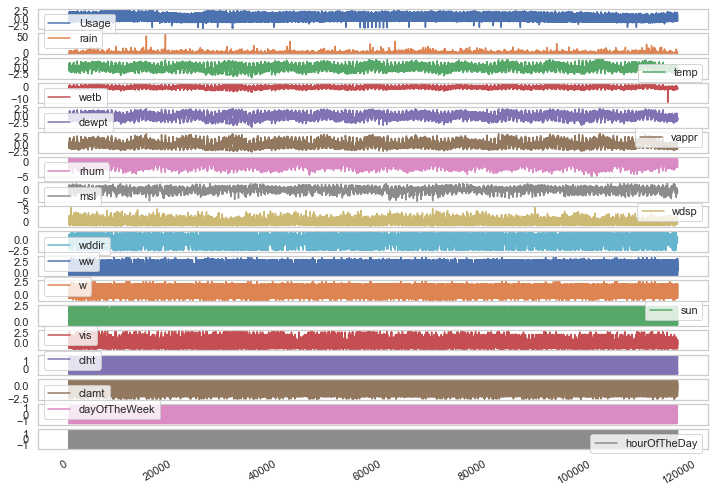

In [88]:
uawdf_features_considered = ['Usage', 'rain', 'temp', 'wetb', 'dewpt', 'vappr', 'rhum', 'msl','wdsp', 'wddir', 'ww', 'w', 'sun', 'vis', 'clht', 'clamt','dayOfTheWeek', 'hourOfTheDay']

uawdf_features = uawdf[uawdf_features_considered]
uawdf_features.index = uawdf.index

uawdf_dataset = np.zeros(shape=(0,0))

uawdf_dataset = uawdf_features.values
uawdf_data_mean = np.nanmean(uawdf_dataset[:TRAIN_SPLIT],axis=0)
uawdf_data_std = np.nanstd(uawdf_dataset[:TRAIN_SPLIT],axis=0)

uawdf_dataset = (uawdf_dataset-uawdf_data_mean)/uawdf_data_std

uawdf_datasetdf = pd.DataFrame(uawdf_dataset, columns = ['Usage', 'rain', 'temp', 'wetb', 'dewpt', 'vappr', 'rhum', 'msl',
       'wdsp', 'wddir', 'ww', 'w', 'sun', 'vis', 'clht', 'clamt',
       'dayOfTheWeek', 'hourOfTheDay'])

ucdUsageDataMaster = uawdf_datasetdf.copy()

uawdf_datasetdf.plot(subplots=True)

In [89]:
uawdf_datasetdf.corr()

,Usage,rain,temp,wetb,dewpt,vappr,rhum,msl,wdsp,wddir,ww,w,sun,vis,clht,clamt,dayOfTheWeek,hourOfTheDay
Usage,1.000000,0.003396,0.104942,0.063771,0.003281,-0.001673,-0.227717,-0.007752,0.159964,-0.014803,0.028072,0.040482,0.319474,0.080182,-0.078462,0.072514,-0.214448,0.088959
rain,0.003396,1.000000,0.004599,0.045207,0.090271,0.092219,0.175927,-0.179504,0.064490,-0.068441,0.402438,0.295012,-0.088512,-0.232875,-0.130156,0.173254,-0.006666,0.006869
temp,0.104942,0.004599,1.000000,0.977001,0.886011,0.870860,-0.426251,0.062755,0.049441,-0.108291,-0.007000,0.023911,0.264197,0.211273,-0.217772,0.216857,-0.001434,0.151965
wetb,0.063771,0.045207,0.977001,1.000000,0.961818,0.947577,-0.231906,0.039383,0.015846,-0.110648,0.059939,0.076119,0.162176,0.095436,-0.254788,0.266776,-0.003993,0.106568
dewpt,0.003281,0.090271,0.886011,0.961818,1.000000,0.987423,0.037444,0.009307,-0.037925,-0.101243,0.136620,0.131303,0.025228,-0.056773,-0.277523,0.303580,-0.007054,0.039975
vappr,-0.001673,0.092219,0.870860,0.947577,0.987423,1.000000,0.046663,0.011313,-0.047065,-0.101864,0.137702,0.131559,0.022486,-0.065388,-0.265189,0.289961,-0.007967,0.039654
rhum,-0.227717,0.175927,-0.426251,-0.231906,0.037444,0.046663,1.000000,-0.110360,-0.204268,0.036565,0.291202,0.204605,-0.506970,-0.576292,-0.061581,0.114674,-0.009986,-0.259036
msl,-0.007752,-0.179504,0.062755,0.039383,0.009307,0.011313,-0.110360,1.000000,-0.341293,-0.017285,-0.292570,-0.341892,0.096544,0.150378,0.127968,-0.148536,-0.002445,0.002885
wdsp,0.159964,0.064490,0.049441,0.015846,-0.037925,-0.047065,-0.204268,-0.341293,1.000000,0.107488,0.198340,0.264918,0.073607,-0.035593,-0.121388,0.125674,0.024864,0.054385
wddir,-0.014803,-0.068441,-0.108291,-0.110648,-0.101243,-0.101864,0.036565,-0.017285,0.107488,1.000000,-0.064298,0.002352,-0.026961,0.170775,0.042792,-0.073929,0.010532,-0.042333


In [90]:
sortedFeatures = uawdf_datasetdf.corr()['Usage'].abs().sort_values(ascending = False)
sortedFeatures

Usage           1.000000
sun             0.319474
rhum            0.227717
dayOfTheWeek    0.214448
wdsp            0.159964
temp            0.104942
hourOfTheDay    0.088959
vis             0.080182
clht            0.078462
clamt           0.072514
wetb            0.063771
w               0.040482
ww              0.028072
wddir           0.014803
msl             0.007752
rain            0.003396
dewpt           0.003281
vappr           0.001673
Name: Usage, dtype: float64

In [91]:
for x in range(len(sortedFeatures)):
    print(sortedFeatures.index[x])

Usage
sun
rhum
dayOfTheWeek
wdsp
temp
hourOfTheDay
vis
clht
clamt
wetb
w
ww
wddir
msl
rain
dewpt
vappr


In [92]:
dates = np.arange(0,1568)

ucdUsageData = ucdUsageDataMaster.copy()

ucdUsageData.columns

Index(['Usage', 'rain', 'temp', 'wetb', 'dewpt', 'vappr', 'rhum', 'msl',
       'wdsp', 'wddir', 'ww', 'w', 'sun', 'vis', 'clht', 'clamt',
       'dayOfTheWeek', 'hourOfTheDay'],
      dtype='object')

In [93]:
ucdUsageData['Usage24Ahead'] = ucdUsageData['Usage'].shift(-24)
ucdUsageData = ucdUsageData.dropna()
bestFeatures = []

for x in range(len(sortedFeatures)):
    if x > 5:
        ucdUsageData.drop([sortedFeatures.index[x]], axis = 1, inplace = True)
    else:
        bestFeatures.append(sortedFeatures.index[x])
        
ucdUsageData.columns

Index(['Usage', 'temp', 'rhum', 'wdsp', 'sun', 'dayOfTheWeek', 'Usage24Ahead'], dtype='object')

Sorted by highest correlation with Usage, the best features are found to be sun, rhum (humidity), dayOfTheWeek, wdsp (windspeed) and temp (temperature)

In [94]:
bestFeatures

['Usage', 'sun', 'rhum', 'dayOfTheWeek', 'wdsp', 'temp']

In [95]:
ucdUsageData.head(30)

,Usage,temp,rhum,wdsp,sun,dayOfTheWeek,Usage24Ahead
0,-1.023995,-0.862192,0.326405,2.018637,-0.527171,-1.499869,-0.969935
1,-1.014063,-0.901872,0.073232,1.837614,-0.527171,-1.499869,-1.007526
2,-1.036442,-0.901872,0.495187,1.656591,-0.527171,-1.499869,-0.991182
3,-0.916880,-0.921713,0.326405,2.018637,-0.527171,-1.499869,-1.010795
4,-1.028270,-1.001074,0.157623,1.837614,-0.527171,-1.499869,-1.027264
5,-0.925555,-1.100276,0.157623,1.656591,-0.527171,-1.499869,-0.869106
6,-0.854019,-1.080436,0.073232,1.475568,-0.527171,-1.499869,-0.241501
7,-0.520101,-0.961394,-0.095551,1.113523,-0.527171,-1.499869,0.994851
8,-0.173862,-0.921713,-0.179942,1.294546,-0.527171,-1.499869,1.790547
9,-0.074919,-0.862192,-0.179942,1.475568,-0.527171,-1.499869,1.980639


# Support Vector Machine

We train the SVM using these features as the dependent variables and the Usage 24 hours ahead as the independent variable to be predicted

In [96]:
ucd_X_svm = np.array(ucdUsageData[bestFeatures])
ucd_y_svm = np.array(ucdUsageData['Usage24Ahead'])

In [97]:
from sklearn.model_selection import train_test_split
ucd_X_train_svm, ucd_X_test_svm, ucd_y_train_svm, ucd_y_test_svm = train_test_split(ucd_X_svm, ucd_y_svm, test_size = 0.2, random_state = 42)

In [98]:
svm_past_history = 24
svm_future_target = 24
svm_STEP = 1

In [99]:
ucdUsageData.drop(['Usage24Ahead'], axis = 1, inplace = True)

In [100]:
ucdUsageDataArray = np.array(ucdUsageData)

In [101]:
def multivariate_data_no_shift(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [102]:
ucd_svm_x_train, ucd_svm_y_train = multivariate_data_no_shift(ucdUsageDataArray[:,0:6], ucdUsageDataArray[:, 0], 0,
                                                   TRAIN_SPLIT, svm_past_history,
                                                   svm_future_target, svm_STEP)
ucd_svm_x_val, ucd_svm_y_val = multivariate_data_no_shift(ucdUsageDataArray[:,0:6], ucdUsageDataArray[:, 0],
                                               TRAIN_SPLIT, None, svm_past_history,
                                               svm_future_target, svm_STEP)

print ('Single window of past history : {}'.format(ucd_svm_x_train[0].shape))

Single window of past history : (24, 6)


In [103]:
ucd_train_data_svm = tf.data.Dataset.from_tensor_slices((ucd_svm_x_train, ucd_svm_y_train))
ucd_train_data_svm = ucd_train_data_svm.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

ucd_val_data_svm = tf.data.Dataset.from_tensor_slices((ucd_svm_x_val, ucd_svm_y_val))
ucd_val_data_svm = ucd_val_data_svm.batch(BATCH_SIZE).repeat()

We fit the SVR and then plot one 24 hour period

In [104]:
ucd_reg_svr = SVR()
ucd_reg_svr.fit(ucd_X_train_svm, ucd_y_train_svm)
ucd_y_pred_svm = ucd_reg_svr.predict(ucd_svm_x_val[1020])

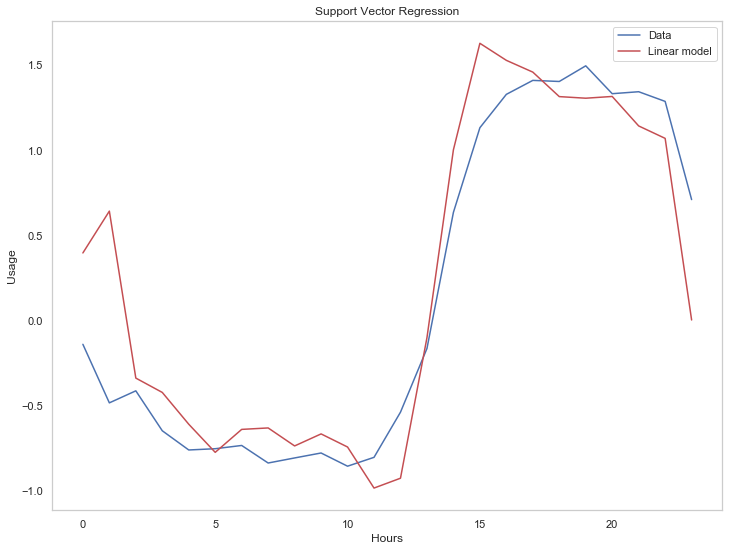

In [105]:
dates = np.arange(0,24)
    
plt.plot(dates, (ucd_svm_y_val[1020]), c='b', label='Data')
plt.plot(dates, ucd_y_pred_svm, c='r', label='Linear model')
    
plt.xlabel('Hours')
plt.ylabel('Usage')
plt.title('Support Vector Regression')
plt.legend()
plt.show()

In [106]:
ucd_full_pred = ucd_reg_svr.predict(ucd_X_test_svm)

Next we plot 100 hours of prediction

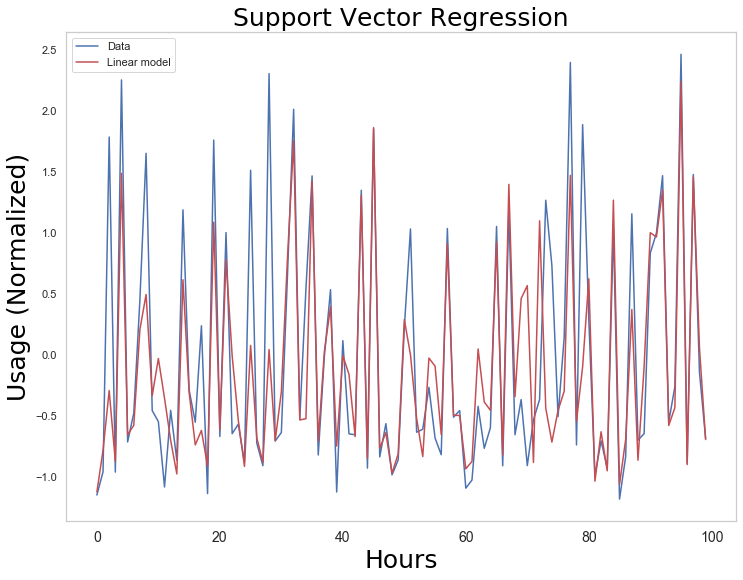

In [107]:
dates = np.arange(0,100)
  
font = {'family': 'DejaVu Sans',
        'color':  'black',
        'weight': 'normal',
        'size': 25,
        }

plt.plot(dates, ucd_y_test_svm[:100], c='b', label='Data')
plt.plot(dates, ucd_full_pred[:100], c='r', label='Linear model')

plt.xticks(fontsize=14)
plt.xlabel('Hours',fontdict=font)
plt.ylabel('Usage (Normalized)',fontdict=font)
plt.title('Support Vector Regression',fontdict=font)
plt.legend()
plt.show()

We then make a batch of 256 predictions

In [108]:
ucd_svm_comp_pred = []

for z in range(2560):
    ucd_svm_comp_pred.append(ucd_reg_svr.predict(ucd_svm_x_val[z]))

# RNN - 24 Hour Training Window

In [109]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'b', label='True Future')
    
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'r', label='Predicted Future')
    
    plt.legend(loc='upper left')
    plt.show()

def create_time_steps(length):
  return list(range(-length, 0))

def plot_train_history(history, title, rmse = False):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    mse = history.history['mean_squared_error']
    if rmse:
        rmse = history.history['root_mean_squared_error']
        val_rmse = history.history['val_root_mean_squared_error']
    
    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.plot(epochs, mse, 'y', label='Mean Squared Error')
    if rmse:
        plt.plot(epochs, rmse, 'g', label='Root Mean Squared Error')
        plt.plot(epochs, val_rmse, 'm', label='Validation Root Mean Squared Error')
    plt.title(title)
    plt.legend()

    plt.show()

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

Here we segment the data into 24 hour periods to train the RNN

In [110]:
mvms_past_history = 24
mvms_future_target = 24
mvms_STEP = 1

x_train_multi, y_train_multi = multivariate_data(ucdUsageDataArray, ucdUsageDataArray[:, 0], 0,
                                                 TRAIN_SPLIT, mvms_past_history,
                                                 mvms_future_target, mvms_STEP)
x_val_multi, y_val_multi = multivariate_data(ucdUsageDataArray, ucdUsageDataArray[:, 0],
                                             TRAIN_SPLIT, None, mvms_past_history,
                                             mvms_future_target, mvms_STEP)

print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target usage to predict : {}'.format(y_train_multi[0].shape))

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

Single window of past history : (24, 6)

 Target usage to predict : (24,)


## Model Design

Here we layout the model and select the hyperparameters

(256, 24)
Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 26s 131ms/step - loss: 0.6978 - mean_squared_error: 0.8088 - root_mean_squared_error: 0.8946 - val_loss: 0.5755 - val_mean_squared_error: 0.5108 - val_root_mean_squared_error: 0.7120
Epoch 2/10
200/200 [==============================] - 21s 104ms/step - loss: 0.5638 - mean_squared_error: 0.6113 - root_mean_squared_error: 0.7812 - val_loss: 0.5525 - val_mean_squared_error: 0.5485 - val_root_mean_squared_error: 0.7321
Epoch 3/10
200/200 [==============================] - 19s 94ms/step - loss: 0.5085 - mean_squared_error: 0.5244 - root_mean_squared_error: 0.7231 - val_loss: 0.4750 - val_mean_squared_error: 0.4156 - val_root_mean_squared_error: 0.6307
Epoch 4/10
200/200 [==============================] - 17s 87ms/step - loss: 0.4810 - mean_squared_error: 0.5014 - root_mean_squared_error: 0.7074 - val_loss: 0.4118 - val_mean_squared_error: 0.3694 - val_root_mean_squared_error: 0.5898
E

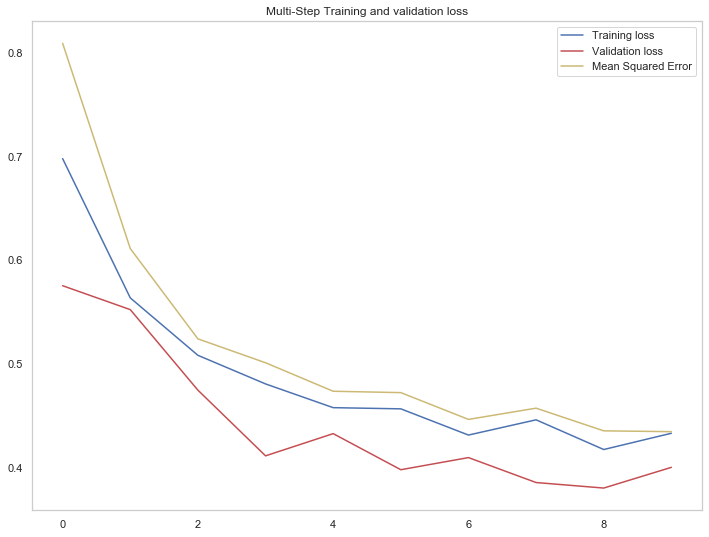

In [111]:
multi_step_model = tf.keras.models.Sequential()

multi_step_model.add(tf.keras.layers.Conv1D(filters=10, kernel_size=3, activation='relu', input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.MaxPooling1D(pool_size=2, strides=2))
multi_step_model.add(tf.keras.layers.Dropout(rate=0.1))

multi_step_model.add(tf.keras.layers.Conv1D(filters=20, kernel_size=3, activation='relu', input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.MaxPooling1D(pool_size=2, strides=2))
multi_step_model.add(tf.keras.layers.Dropout(rate=0.1))

multi_step_model.add(tf.keras.layers.LSTM(200, activation='relu',return_sequences=True))
multi_step_model.add(tf.keras.layers.LSTM(25, activation='relu'))

multi_step_model.add(tf.keras.layers.Dropout(rate=0.3))

multi_step_model.add(tf.keras.layers.Dense(24))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae', metrics=['mean_squared_error',
                                                                                                    root_mean_squared_error])

for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

multi_step_history = multi_step_model.fit(train_data_multi, epochs=10,
                                          steps_per_epoch=200,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

We then make our predictions using the model

In [112]:
rnn_data = []
rnn_comp_pred = []
ucd_svr_comp_pred = []
    
for x, y in val_data_multi.take(10):
    for a in range(len(x)):
        rnn_data.append(y[a])
        ucd_svr_comp_pred.append(ucd_reg_svr.predict(x[a]))
        rnn_comp_pred.append(multi_step_model.predict(x)[a])

In [113]:
def get30days(mainArray):
    firstBool = False
    d30a = np.array([])
    
    for x in range(30):
        if firstBool == False:
            d30a = np.concatenate((mainArray[int(24*x)], mainArray[int(24*(x+1))]), axis = 0)
            firstBool = True
        else:
            d30a = np.concatenate((d30a, mainArray[int(24*(x+1))]), axis = 0)
    
    return d30a

In [114]:
rnn_data_30 = get30days(rnn_data)
rnn_pred_30 = get30days(rnn_comp_pred)
svr_pred_30 = get30days(ucd_svr_comp_pred)

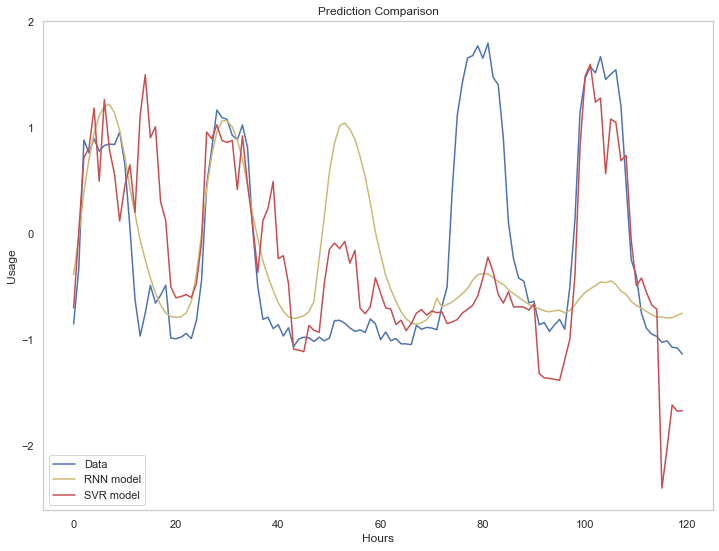

In [115]:
dates = np.arange(0,len(rnn_data_30[:120]))

plt.plot(dates, rnn_data_30[:120], c='b', label='Data')
plt.plot(dates, rnn_pred_30[:120], c= 'y', label='RNN model')
plt.plot(dates, svr_pred_30[:120], c= 'r', label='SVR model')
    
plt.xlabel('Hours')
plt.ylabel('Usage')
plt.title('Prediction Comparison')
plt.legend()
plt.show()

In [116]:
mean_absolute_error(rnn_data_30,rnn_pred_30)

0.4260903896031725

In [117]:
mean_absolute_error(rnn_data_30,svr_pred_30)

0.6604648194344461

# Evaluation

In [118]:
def twentyfour_hour_mae(y_pred, y_true):
    mae = []
    for a in range(len(y_pred)):
        mae.append(mean_absolute_error(y_pred[a],y_true[a]))
    
    return (np.array(mae))

def twentyfour_hour_rmse(y_pred, y_true):
    rmse = []
    for a in range(len(y_pred)):
        rmse.append(simple_rmse(y_pred[a],y_true[a]))
    
    return (np.array(rmse))

def twentyfour_hour_r_squared(y_pred, y_true):
    r_squared = []
    for a in range(len(y_pred)):
        r_squared.append(get_r_squared(y_pred[a],y_true[a]))
    
    return (np.array(r_squared))

def smape(actual, forecasted):
    return 1/len(actual) * np.sum(2 * np.abs(forecasted - actual) / (np.abs(actual) + np.abs(forecasted)))

def twentyfour_hour_smape(y_pred, y_true):
    smape_arr = []
    for a in range(len(y_pred)):
        smape_arr.append(smape(y_pred[a],y_true[a]))
    
    return (np.array(smape_arr))

from sklearn.metrics import mean_squared_error,mean_absolute_error
from math import sqrt

def simple_rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

We evaluate the dating using MAE, RMSE and SMAPE and plot the results

In [119]:
rnn_batch_mae = (twentyfour_hour_mae(rnn_comp_pred,rnn_data))
rnn_batch_rmse = (twentyfour_hour_rmse(rnn_comp_pred,rnn_data))
rnn_batch_smape = (twentyfour_hour_smape(rnn_data,rnn_comp_pred))

svm_batch_mae = (twentyfour_hour_mae(ucd_svm_comp_pred,rnn_data))
svm_batch_rmse = (twentyfour_hour_rmse(ucd_svm_comp_pred,rnn_data))
svm_batch_smape = (twentyfour_hour_smape(rnn_data, ucd_svm_comp_pred))

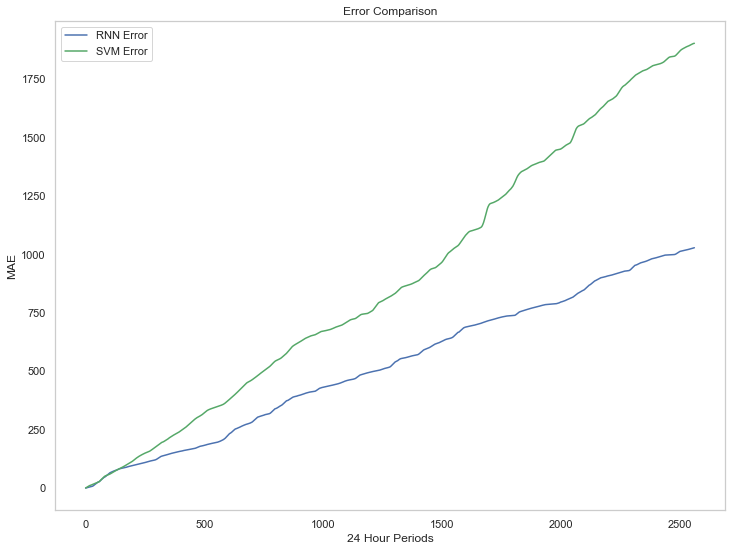

In [120]:
dates = np.arange(0,2560)

plt.plot(dates, rnn_batch_mae.cumsum(), color = 'b', label='RNN Error')
plt.plot(dates, svm_batch_mae.cumsum(), color = 'g', label='SVM Error')

plt.xlabel('24 Hour Periods')
plt.ylabel('MAE')
plt.title('Error Comparison')
plt.legend()
plt.show()

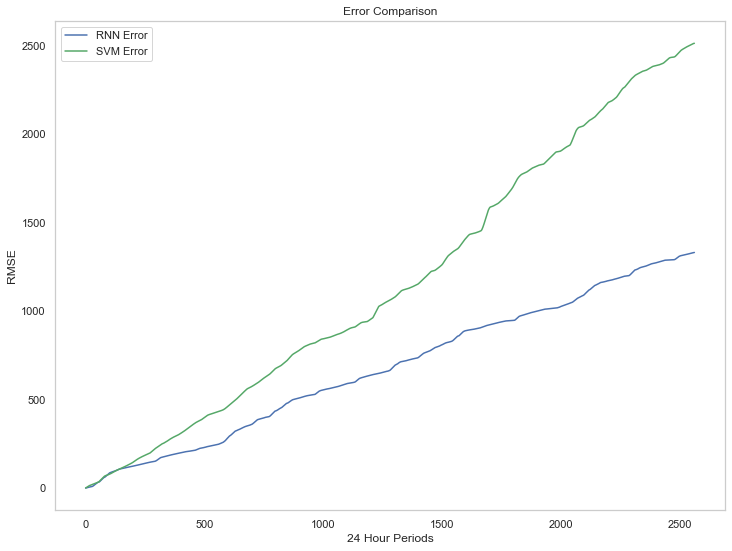

In [121]:
dates = np.arange(0,2560)

plt.plot(dates, rnn_batch_rmse.cumsum(), color = 'b', label='RNN Error')
plt.plot(dates, svm_batch_rmse.cumsum(), color = 'g', label='SVM Error')

plt.xlabel('24 Hour Periods')
plt.ylabel('RMSE')
plt.title('Error Comparison')
plt.legend()
plt.show()

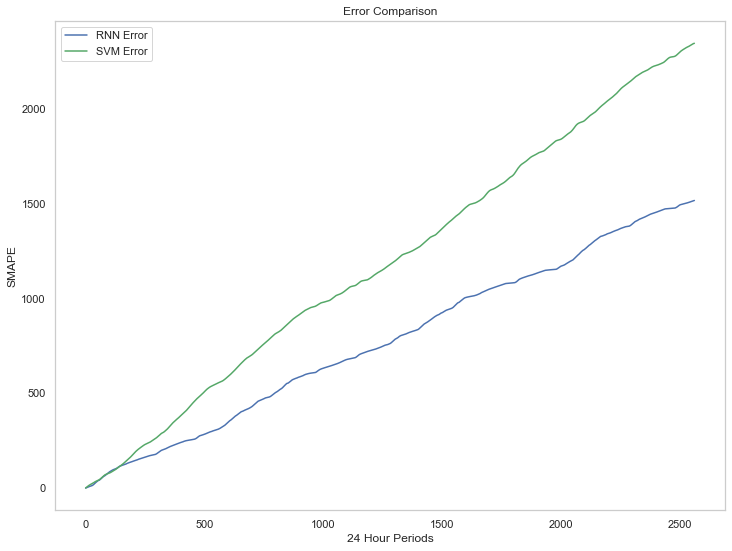

In [122]:
dates = np.arange(0,2560)

plt.plot(dates, rnn_batch_smape.cumsum(), color = 'b', label='RNN Error')
plt.plot(dates, svm_batch_smape.cumsum(), color = 'g', label='SVM Error')

plt.xlabel('24 Hour Periods')
plt.ylabel('SMAPE')
plt.title('Error Comparison')
plt.legend()
plt.show()

In [123]:
svmBars = [np.mean(svm_batch_mae), np.mean(svm_batch_rmse)]
rnnBars = [np.mean(rnn_batch_mae), np.mean(rnn_batch_rmse)]

groupedBarErrorData = np.array([["SVM", "MAE", np.mean(svm_batch_mae)],
                                ["SVM","RMSE", np.mean(svm_batch_rmse)], 
                                ["SVM", "SMAPE", np.mean(svm_batch_smape)], 
                                ["RNN", "MAE", np.mean(rnn_batch_mae)],
                                ["RNN", "RMSE", np.mean(rnn_batch_rmse)],
                                ["RNN", "SMAPE", np.mean(rnn_batch_smape)]
                               ])

In [124]:
groupedBarErrorDataFrame = pd.DataFrame(groupedBarErrorData, columns=["Model", "Metric", "Accuracy"])

groupedBarErrorDataFrame.head(10)

,Model,Metric,Accuracy
0,SVM,MAE,0.7434441645019632
1,SVM,RMSE,0.9813983379258875
2,SVM,SMAPE,0.9163156944020351
3,RNN,MAE,0.4017499418206853
4,RNN,RMSE,0.5199403922180192
5,RNN,SMAPE,0.5925981855791065


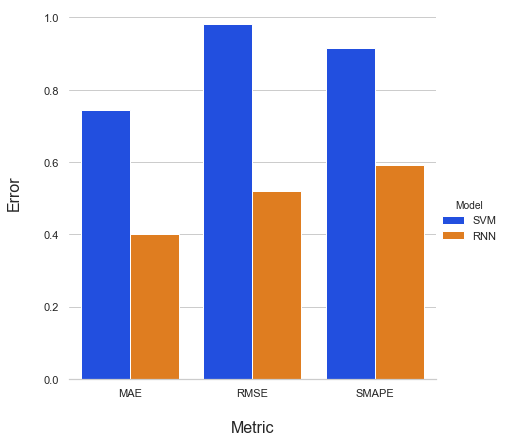

In [125]:
import seaborn as sns
sns.set(style="whitegrid")

g = sns.catplot(x="Metric", y="Accuracy", hue="Model", data=groupedBarErrorDataFrame,
                height=6, kind="bar", palette="bright")
g.despine(left=True)
g.set_ylabels("Error\n", fontsize = 16)
g.set_xlabels("\nMetric", fontsize = 16)